In [1]:
import pandas as pd

data = pd.read_csv("final_merged_1min.csv", index_col=0)
data.isna().sum()
print("Size before dropna", len(data))
data.dropna(how="any", inplace=True)
print("Size after dropna", len(data))

Size before dropna 56250
Size after dropna 56125


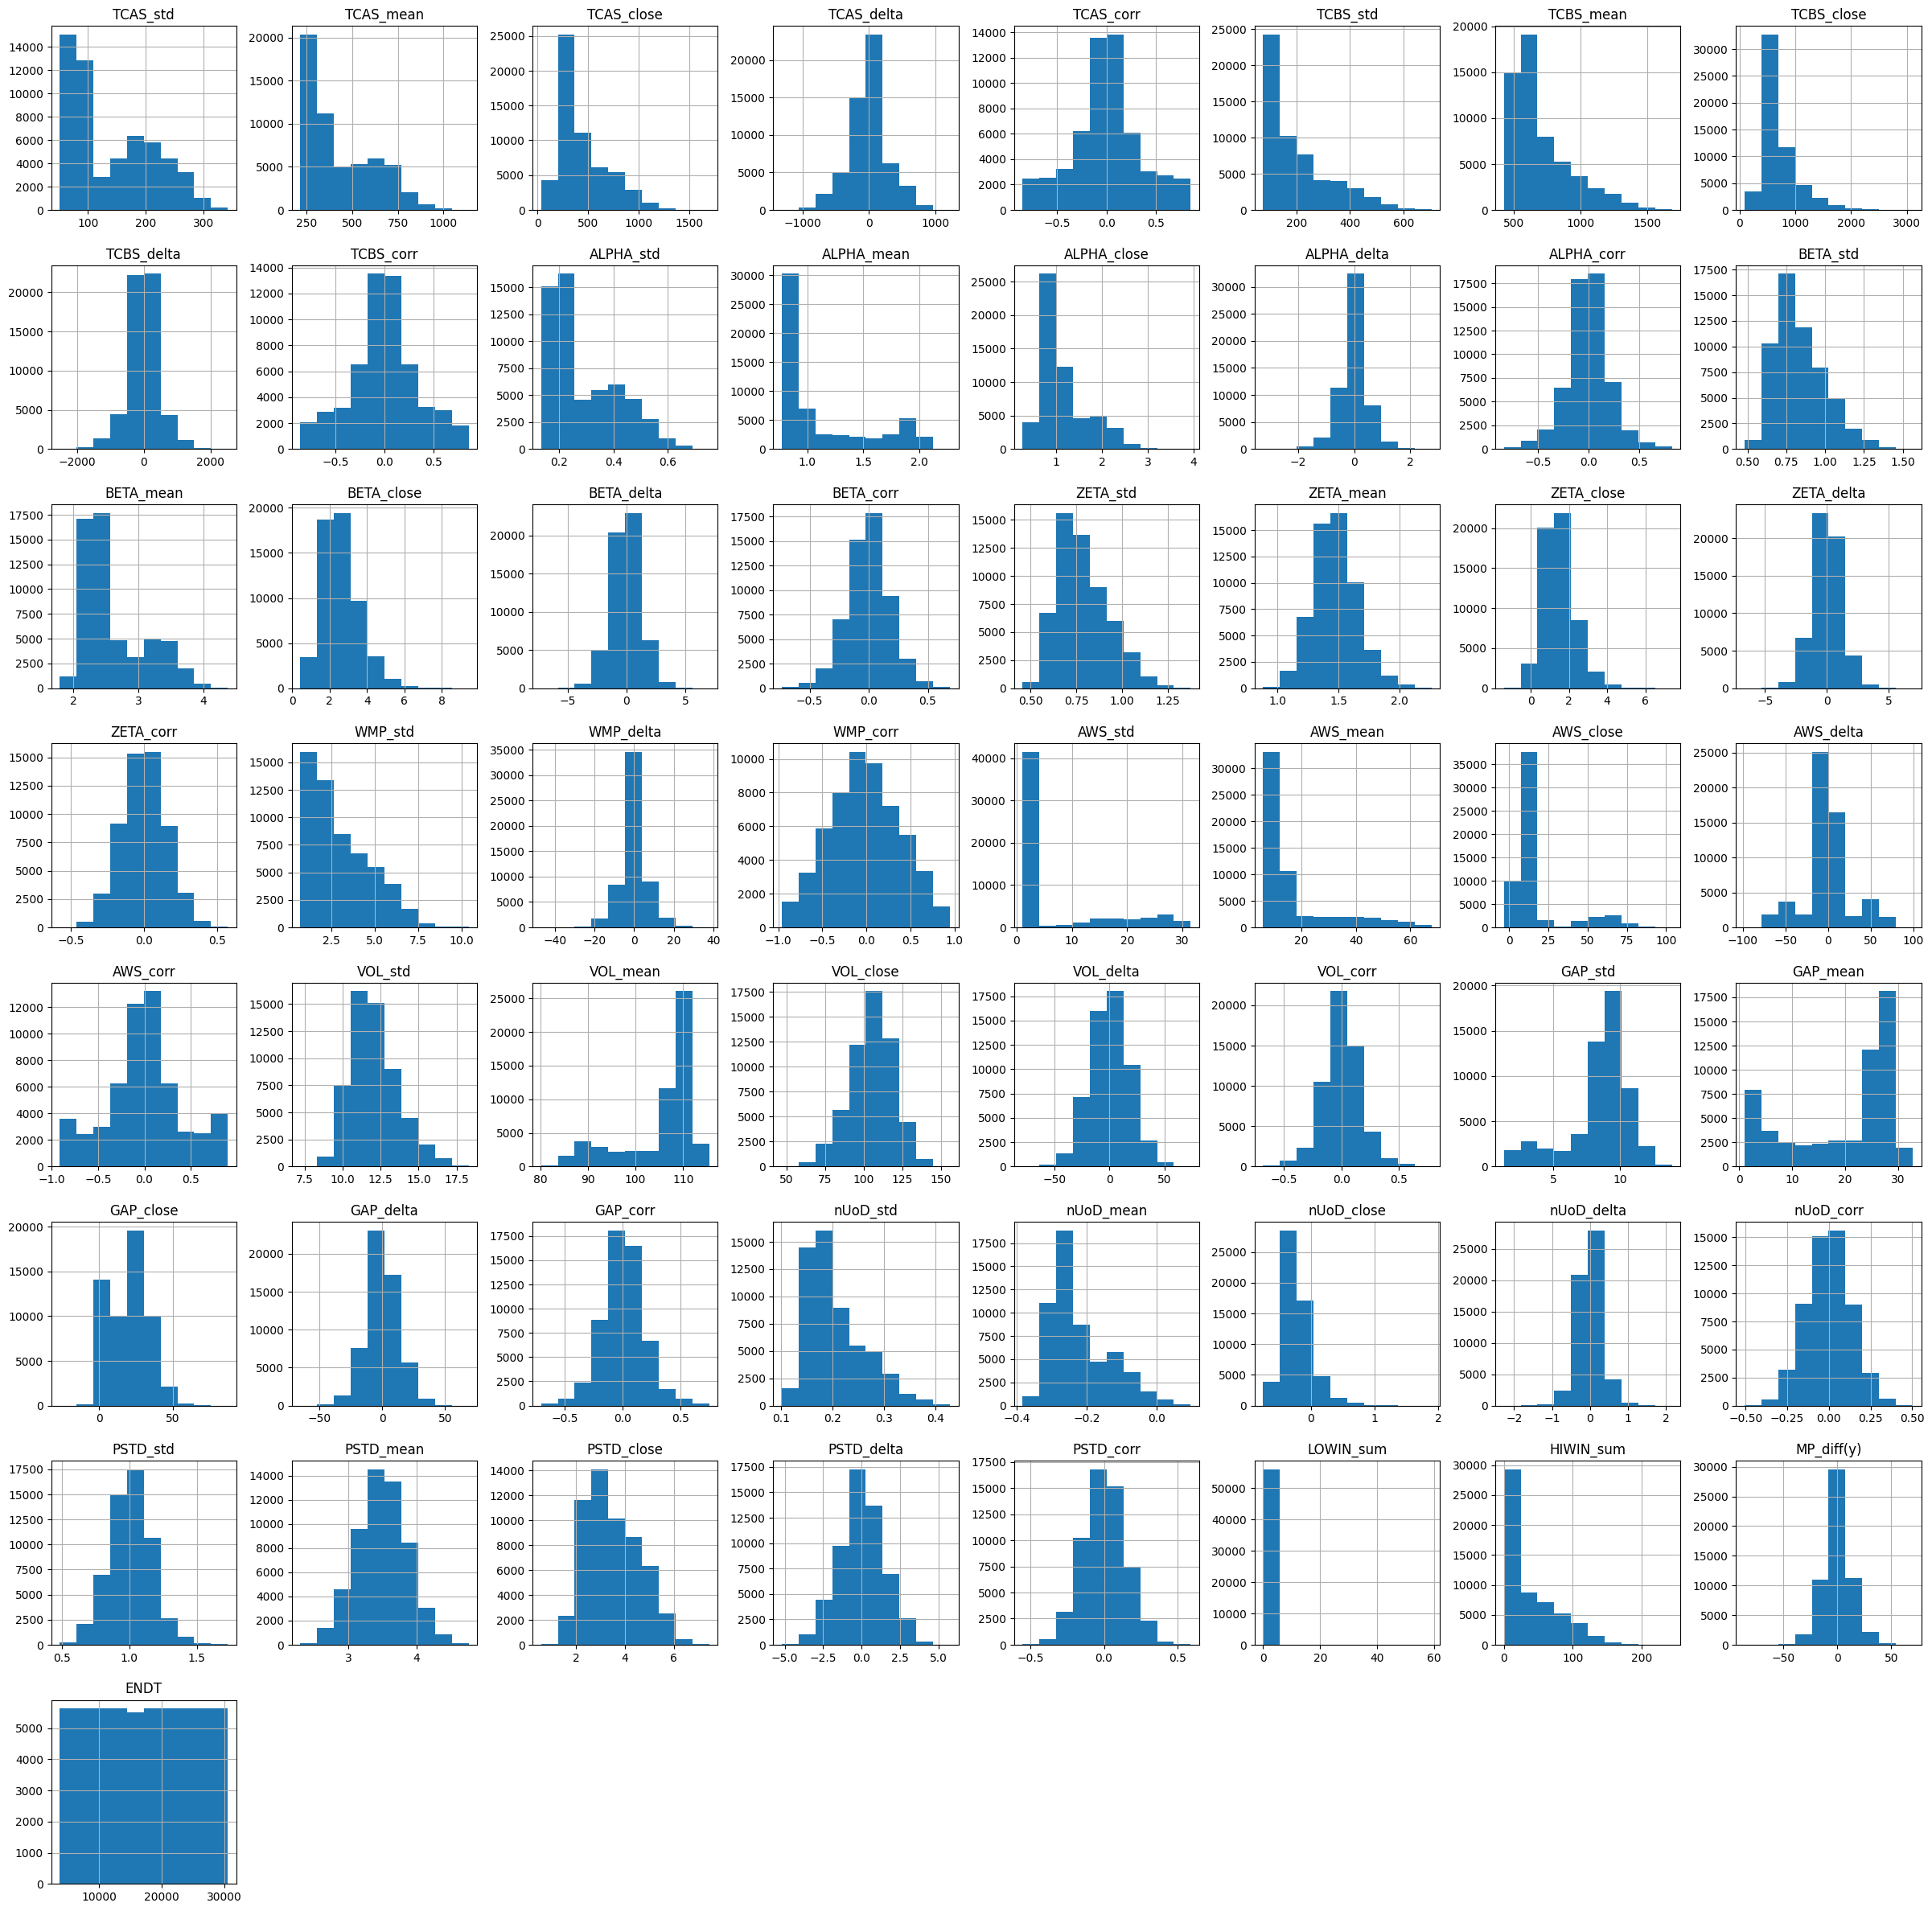

In [2]:
import matplotlib.pyplot as plt
data.hist(figsize=(30,30))
plt.show()

In [3]:
x_features = list(data)
x_features.remove("MP_diff(y)")
x_features.remove("ENDT")
x_features.remove("GAP_std")
x_features.remove("GAP_mean")
x_features.remove("GAP_close")
x_features.remove("GAP_delta")
x_features.remove("GAP_corr")

import numpy as np

# scale delta and std by mean
for col in x_features:
    if "WMP" not in col:
        if "std" in col or "delta" in col or "close" in col:
            data[col] = data[col] / data[col.split("_")[0] + "_mean"]

# scale data between 0 and 1
for col in x_features:
    #data[col] = np.log(data[col] + data[col].min())
    data[col] = (data[col] - data[col].min()) / (data[col].max() - data[col].min())
    if data[col].median() < 0.2:
        data[col] = np.log(data[col] + 1)

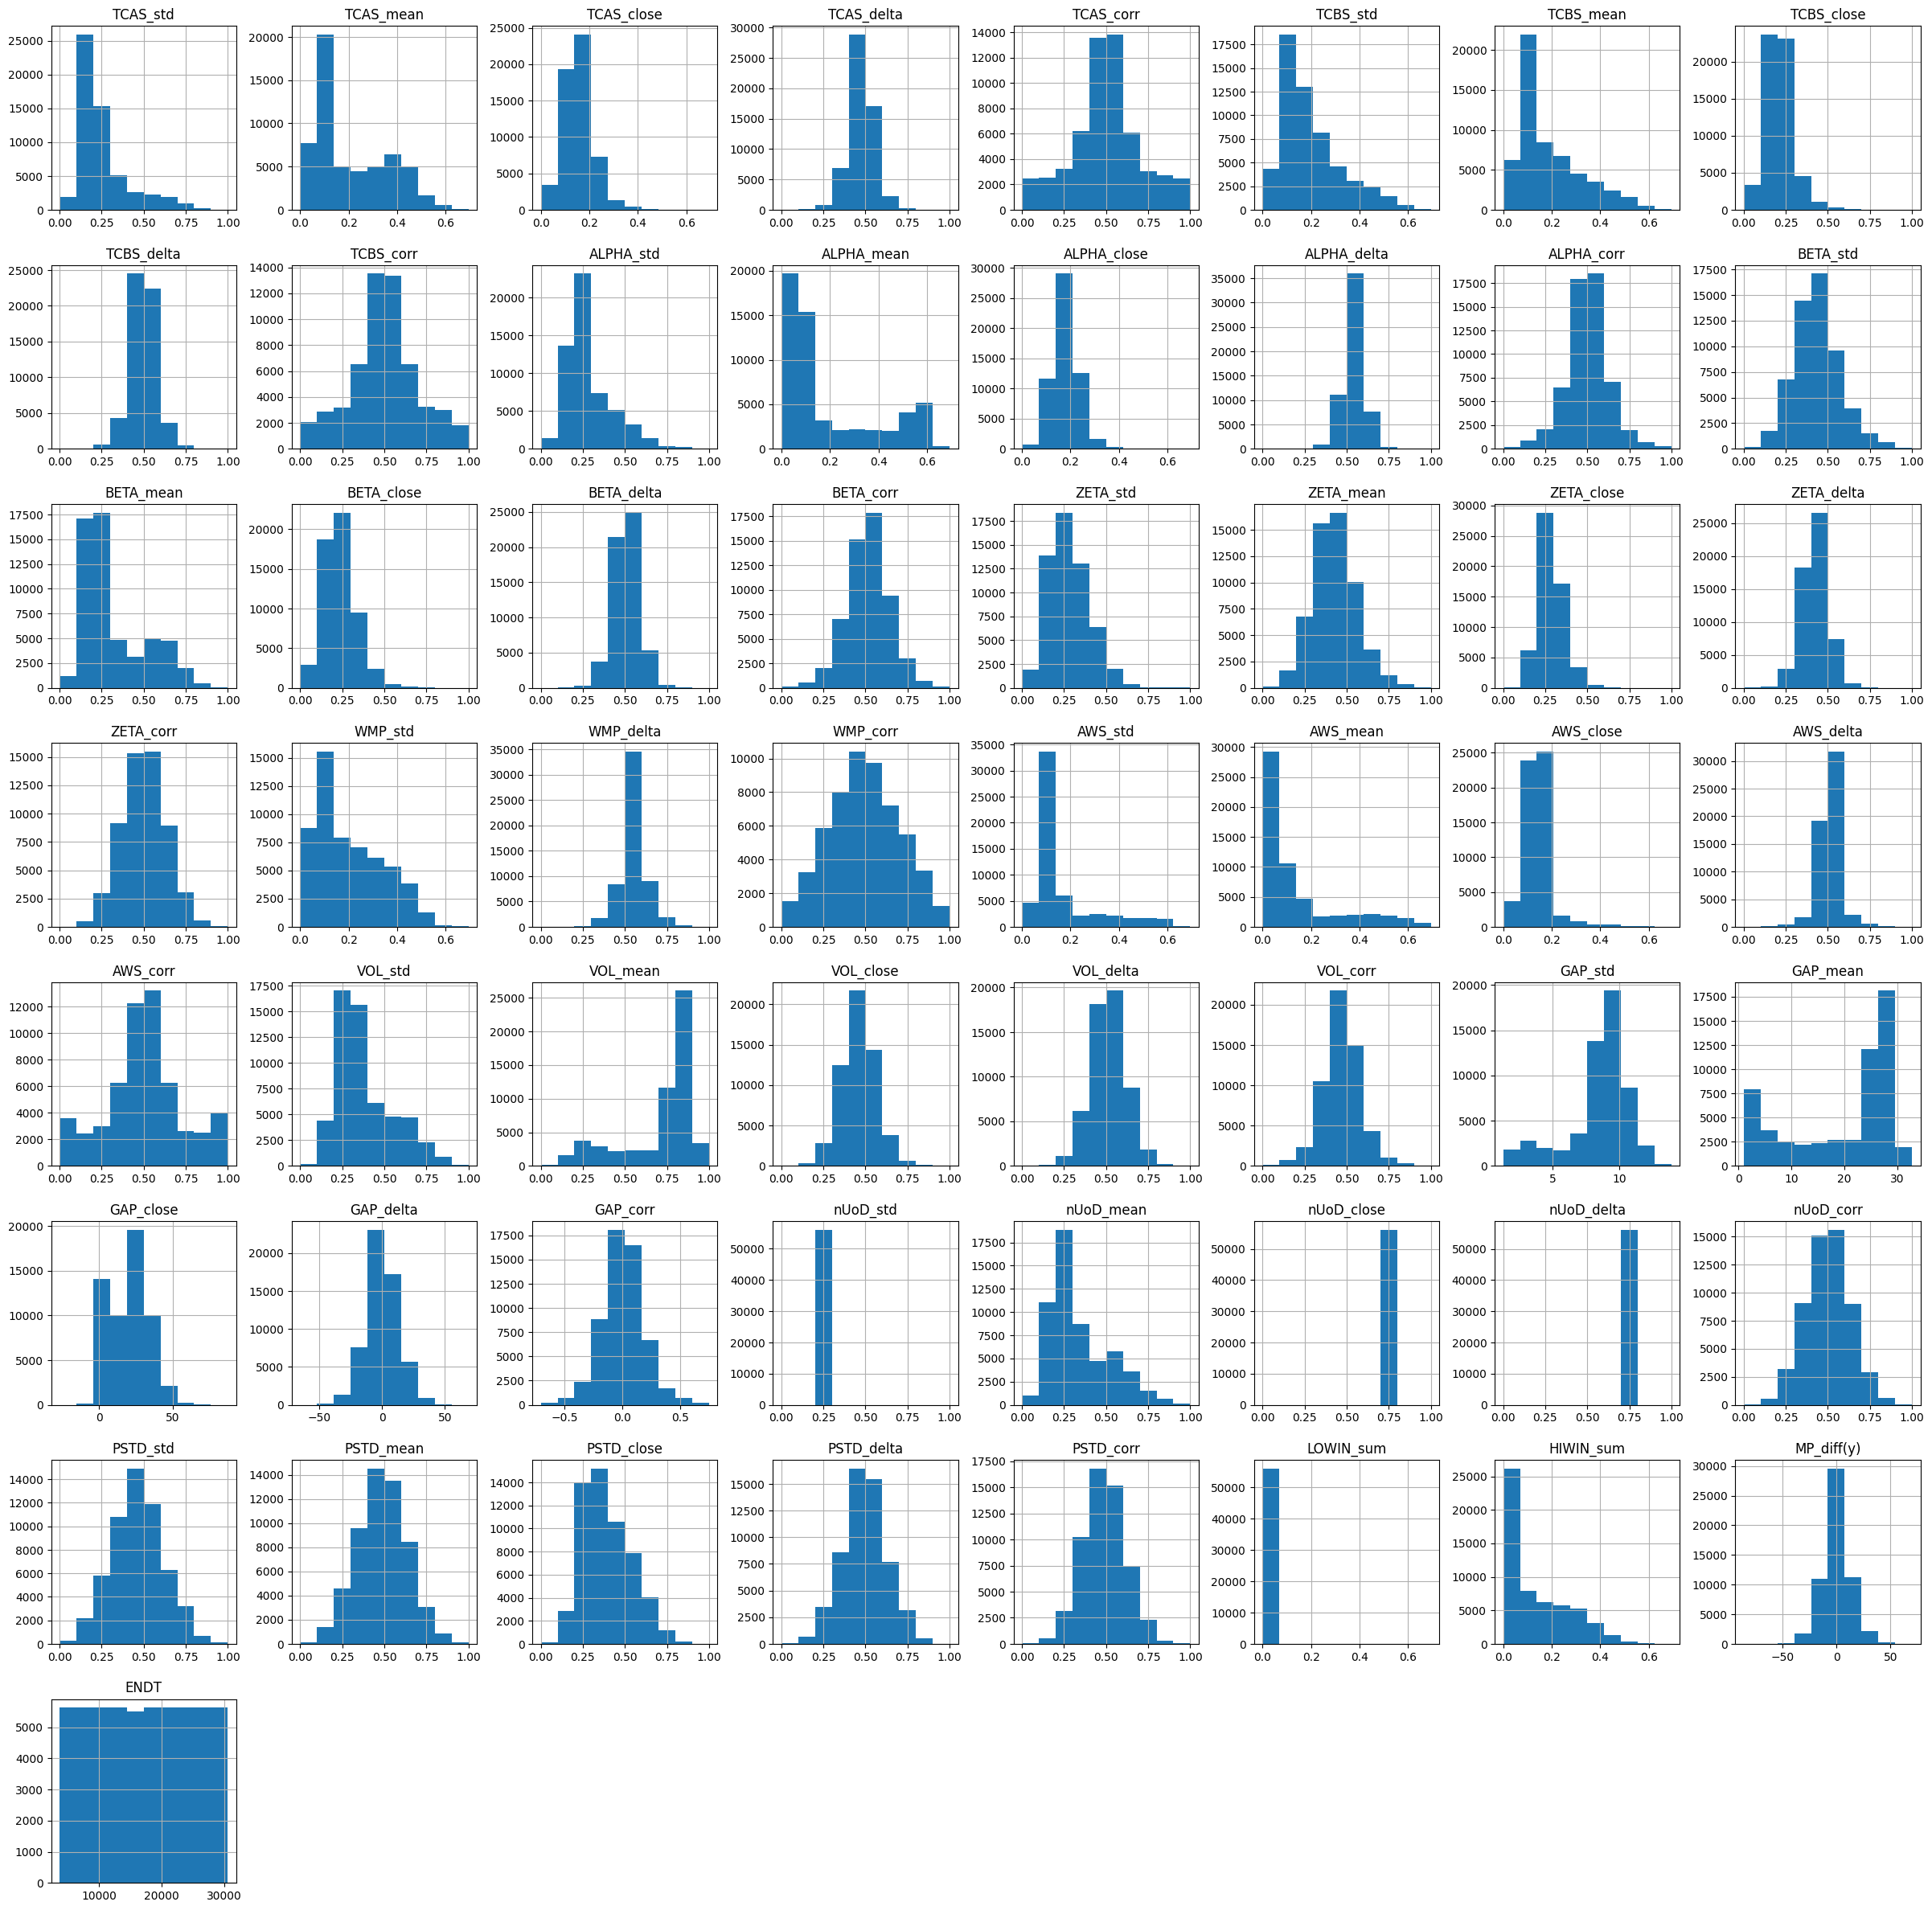

In [4]:
data.hist(figsize=(30,30))
plt.show()

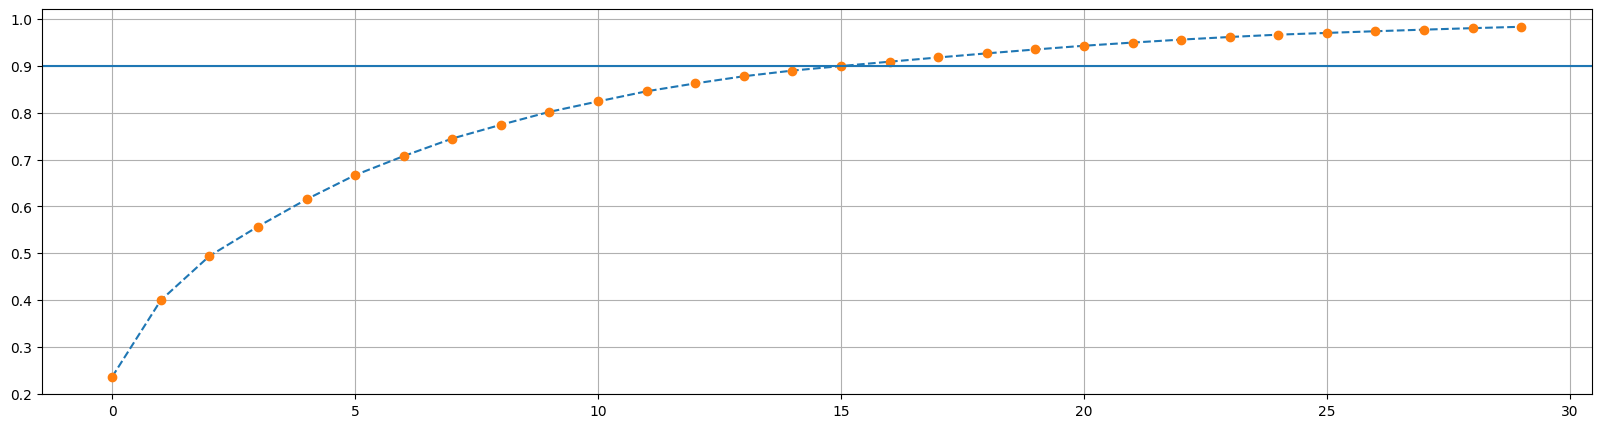

In [5]:
# apply pca
from sklearn.decomposition import PCA
import numpy as np

pca = PCA(n_components=30)
pca_vectors = pca.fit_transform(data[x_features])

plt.figure(figsize=(20,5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), linestyle = "--")
plt.plot(np.cumsum(pca.explained_variance_ratio_), 'o')
plt.axhline(0.9)
plt.grid()

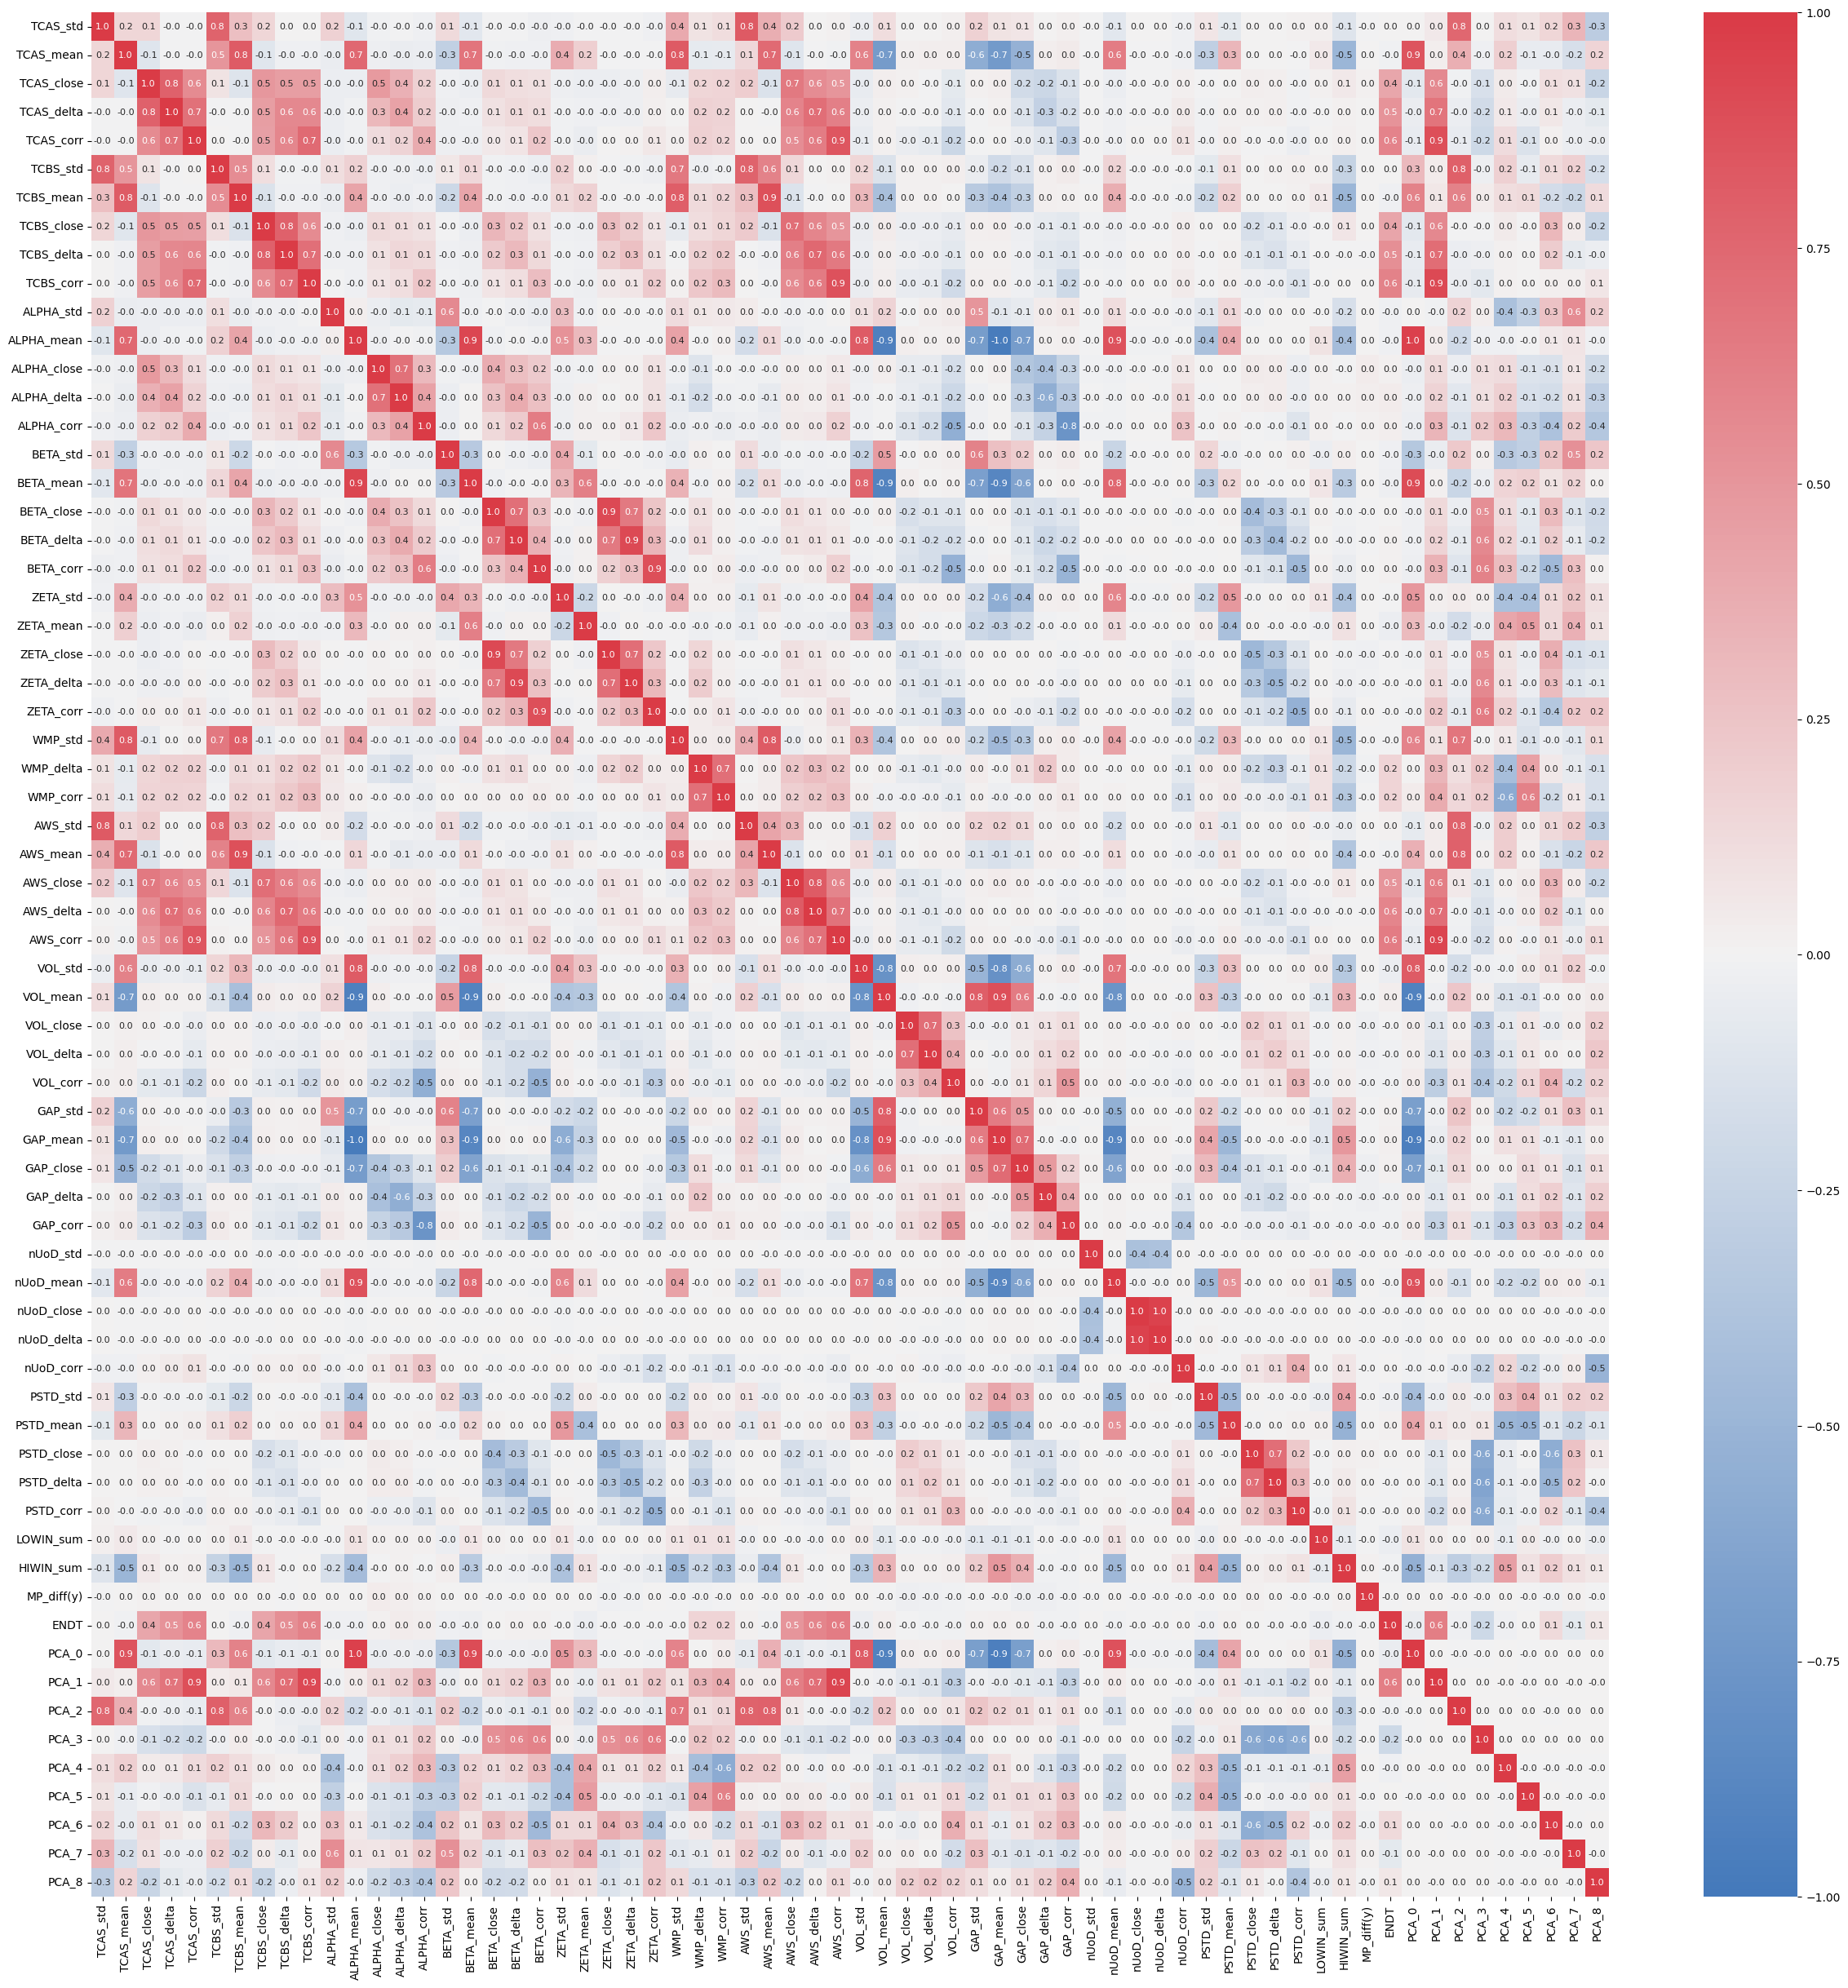

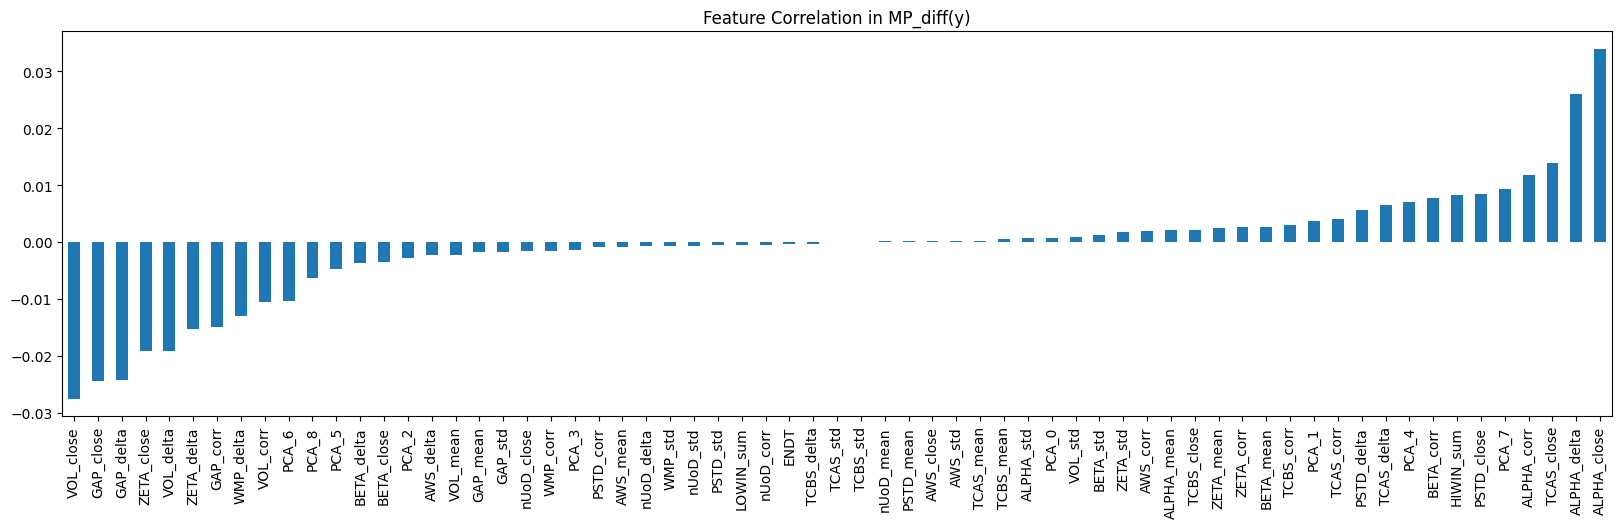

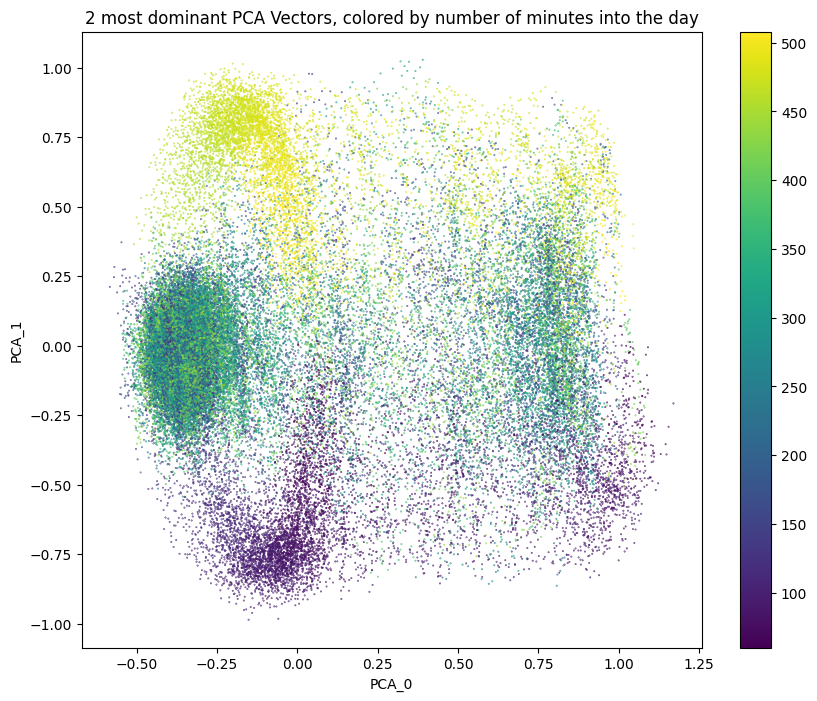

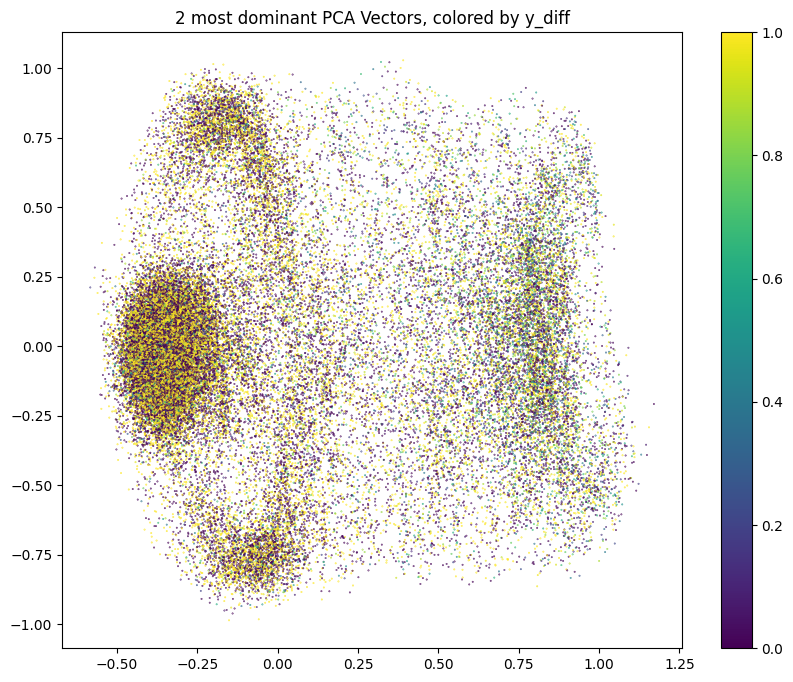

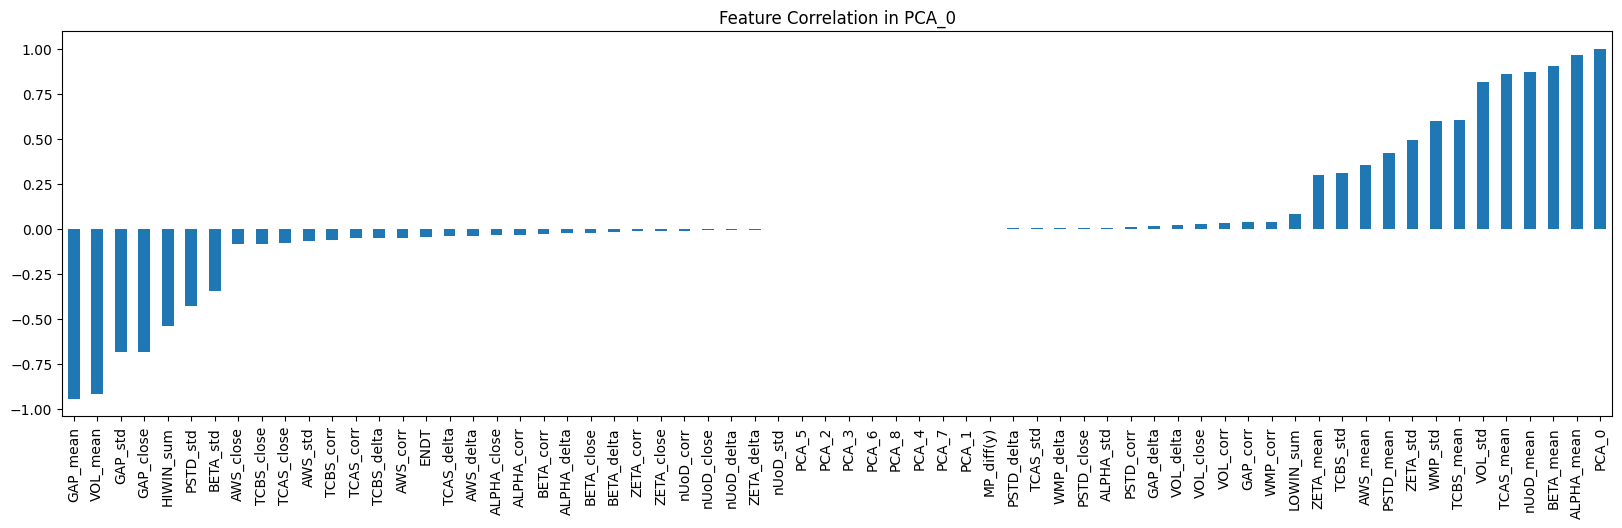

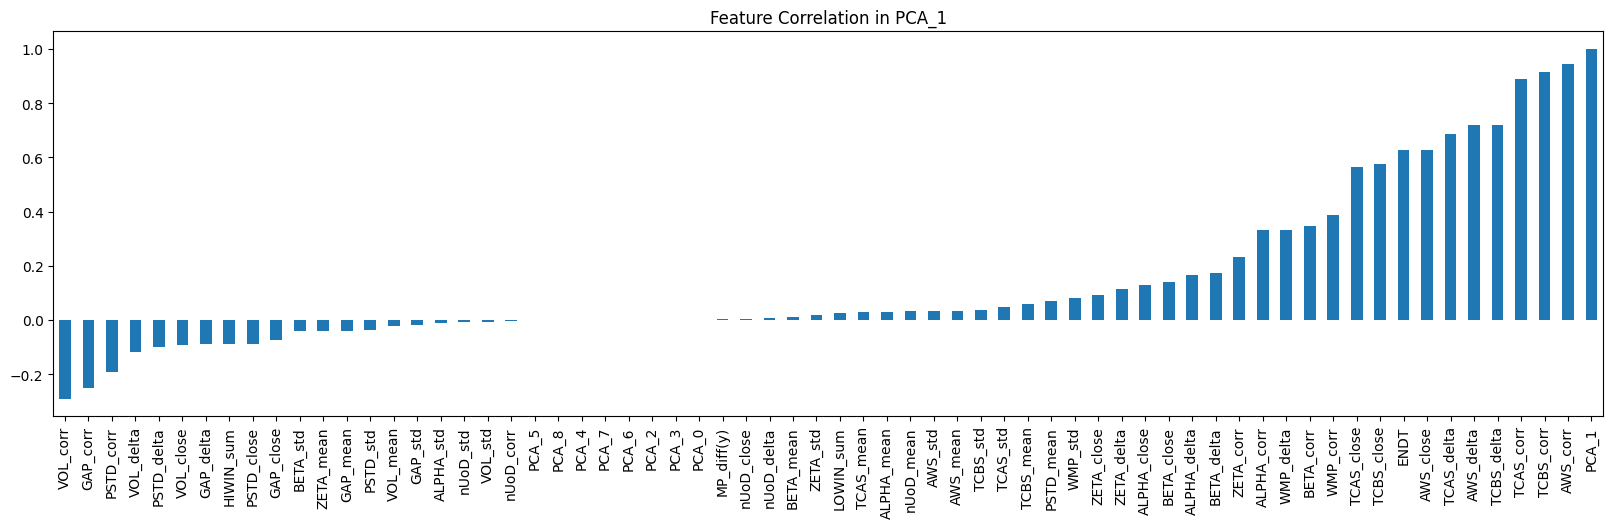

In [6]:
X = pca_vectors[:,:9]
y_diff = data["MP_diff(y)"]
import seaborn as sns


for i in range(X.shape[1]):
    data[f"PCA_{i}"] = X[:,i]

plt.figure(figsize=(30,30))
corr_map = data.corr()
cmap = sns.diverging_palette(250, 10, as_cmap=True)
sns.heatmap(corr_map, vmin=-1, vmax=1, cmap=cmap, center=0, annot=True, fmt=".1f", annot_kws={"size": 8})
plt.show()

corr_map[corr_map.index != "MP_diff(y)"]["MP_diff(y)"].sort_values().plot(kind = "bar", figsize=(20,5))
plt.title("Feature Correlation in MP_diff(y)")
plt.show()

plt.figure(figsize=(10,8))
plt.title("2 most dominant PCA Vectors, colored by number of minutes into the day")
plt.scatter(X[:,0], X[:,1], c = data.index.to_numpy(), s = 1/2**3)
plt.xlabel("PCA_0")
plt.ylabel("PCA_1")
plt.colorbar()
plt.show()
plt.figure(figsize=(10,8))
plt.title("2 most dominant PCA Vectors, colored by y_diff")
plt.scatter(X[:,0], X[:,1], c = 1/ (1 + np.exp(-y_diff.to_numpy())), s = 1/2**3)
plt.colorbar()
plt.show()

corr_map["PCA_0"].sort_values().plot(kind = "bar", figsize=(20,5))
plt.title("Feature Correlation in PCA_0")
plt.show()
corr_map["PCA_1"].sort_values().plot(kind = "bar", figsize=(20,5))
plt.title("Feature Correlation in PCA_1")
plt.show()

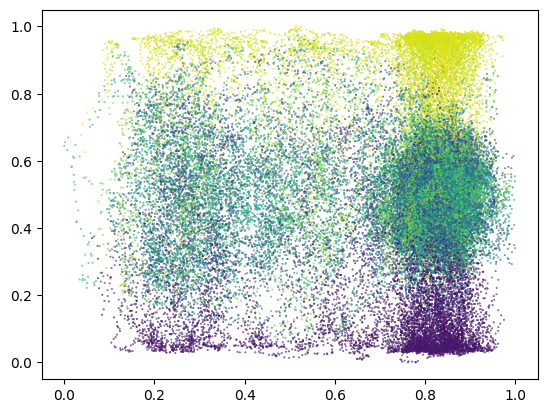

In [7]:
plt.scatter(data["VOL_mean"], data["AWS_corr"], s = 1/2**3, c = data["ENDT"])

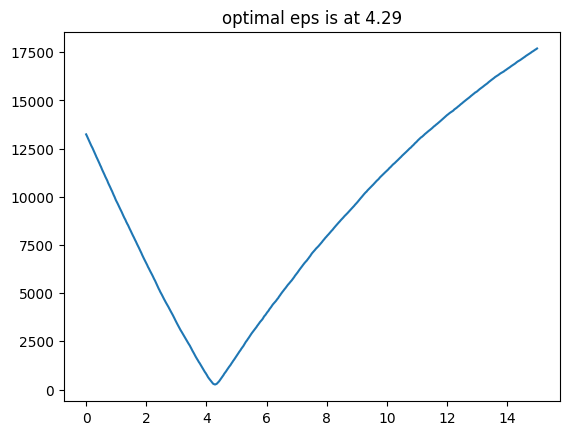

In [8]:
eps_vals = np.arange(0, 15, 0.01)

def eps_y_bool(arr, eps):
    return np.std([np.sum(arr > eps),np.sum(arr < -eps), np.sum( (arr < eps) & (arr > -eps) )])
    
split_ratios = []
for eps in eps_vals:
    split_ratios.append(eps_y_bool(y_diff, eps))

plt.title(f"optimal eps is at {eps_vals[np.argmin(split_ratios)]}")
plt.plot(eps_vals, split_ratios)
plt.show()

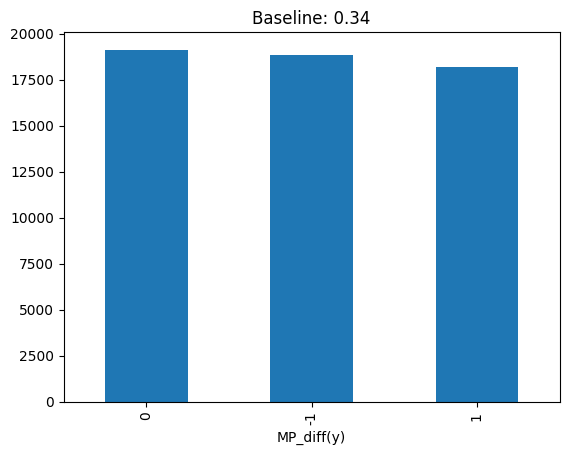

In [35]:
def gen_y_bool(y):
    if abs(y) <= 4.4:
        return 0
    elif y > 0:
        return 1
    else:
        return -1
    
y_bool = y_diff.apply(gen_y_bool)
y_bool_splits = y_bool.value_counts()
y_bool_splits.plot(kind = "bar")
baseline = np.max(y_bool_splits) / len(data)
plt.title(f"Baseline: {baseline:.2f}")
plt.show()

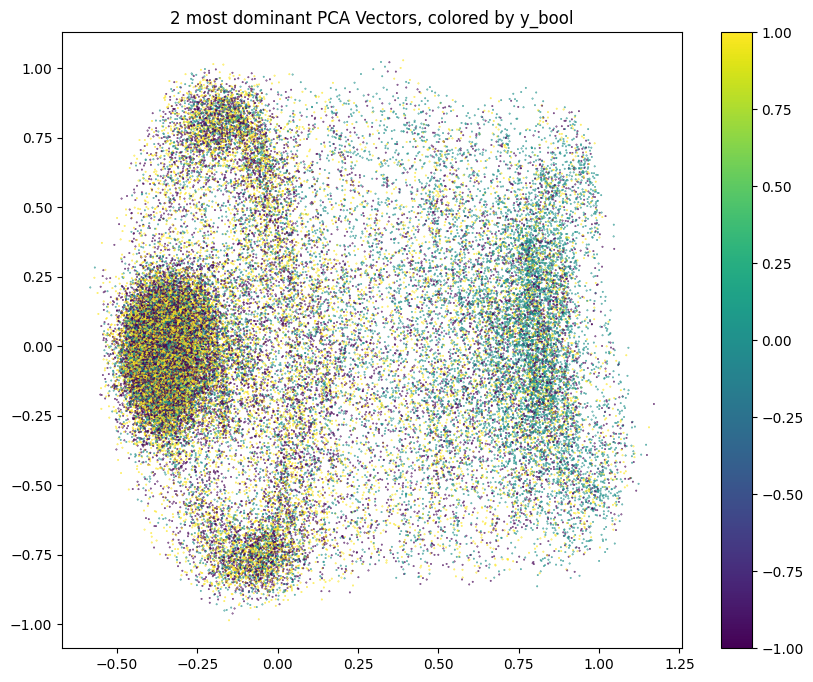

In [36]:
plt.figure(figsize=(10,8))
plt.title("2 most dominant PCA Vectors, colored by y_bool")
plt.scatter(X[:,0], X[:,1], c = y_bool.to_numpy(), s = 1/2**3)
plt.colorbar()
plt.show()

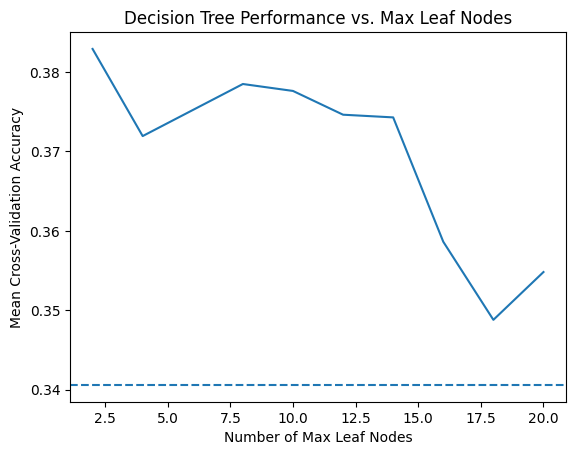

In [37]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score


cv_scores = []
tree_nodes = [2,4,8,10,12,14,16,18,20]

mask = y_bool != 0

for n in tree_nodes:
    clf = DecisionTreeClassifier(max_leaf_nodes=n)
    scores = cross_val_score(clf, data[x_features], y_bool, cv=5)  # Assuming you have data X and labels y
    cv_scores.append(scores.mean())

plt.plot(tree_nodes, cv_scores)
plt.xlabel('Number of Max Leaf Nodes')
plt.ylabel('Mean Cross-Validation Accuracy')
plt.title('Decision Tree Performance vs. Max Leaf Nodes')
plt.axhline(baseline, linestyle = "--")
plt.show()

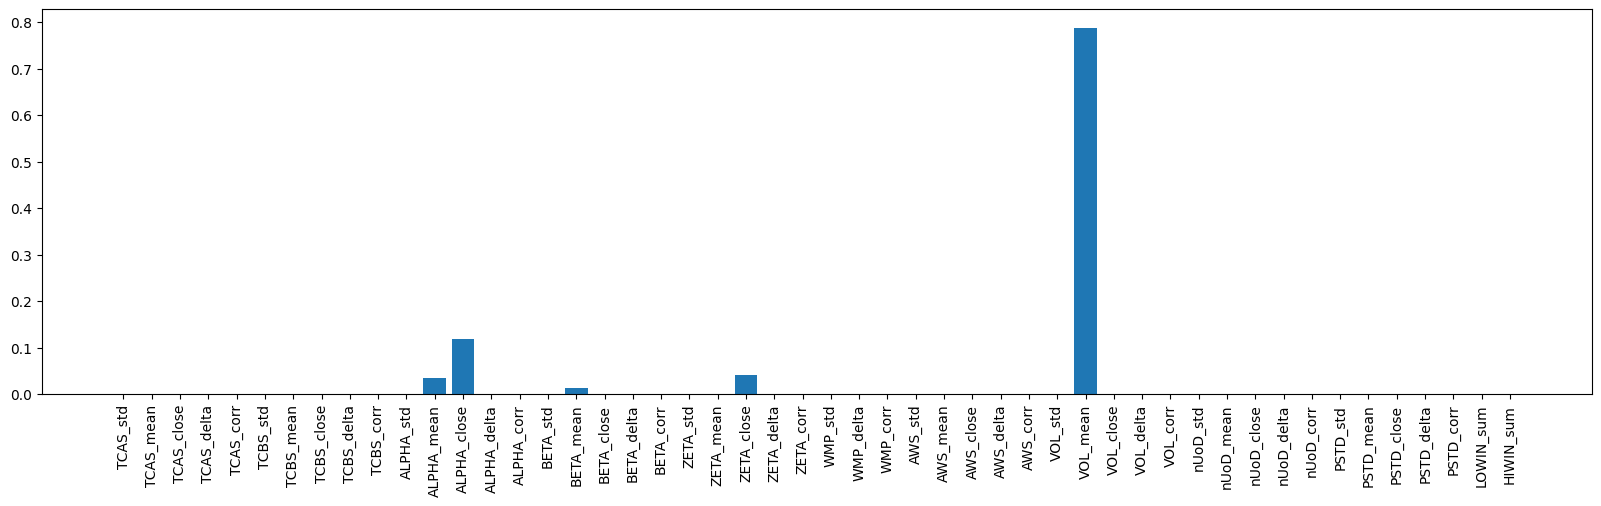

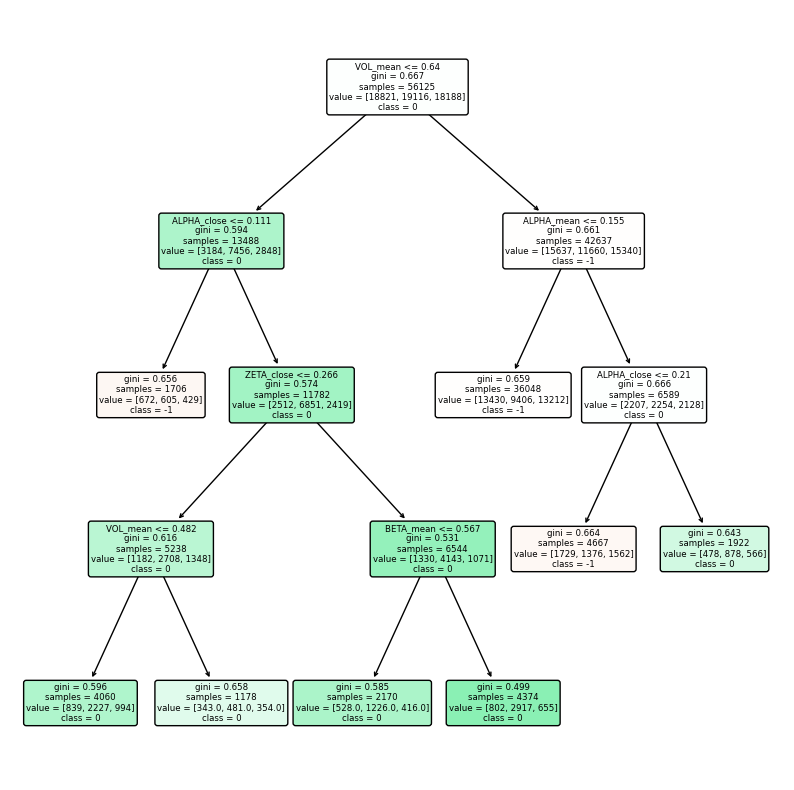

In [38]:
clf = DecisionTreeClassifier(max_leaf_nodes=8)
clf.fit(data[x_features],y_bool)

plt.figure(figsize=(20,5))
plt.bar(x_features, clf.feature_importances_)
plt.xticks(rotation = 90)
plt.show()

from sklearn.tree import plot_tree

plt.figure(figsize=(10,10))
plot_tree(clf, feature_names=x_features, class_names=[str(a) for a in clf.classes_], filled=True, rounded=True)
plt.show()

In [40]:
from sklearn.metrics import confusion_matrix

ypred = clf.predict(data[x_features])
ytrue = y_bool.to_numpy()
conf_matrix = confusion_matrix(ytrue, ypred, labels=clf.classes_)

for i, clas in enumerate(clf.classes_):
    print(f"Class {clas} Analysis...")
    
    print("Baseline =", np.mean(ytrue == clas))
    TP = conf_matrix[i, i]
    FP = np.sum(conf_matrix[:, i]) - TP
    FN = np.sum(conf_matrix[i, :]) - TP
    TN = np.sum(conf_matrix) - TP - FP - FN
    
    print("TP =", TP)
    print("FP =", FP)
    print("TN =", TN)
    print("FN =", FN)
    
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    print("Precision =", precision)
    print("Recall =", recall)
    print("F1 Score =", f1)
    print()


Class -1 Analysis...
Baseline = 0.33534075723830736
TP = 15831
FP = 26590
TN = 10714
FN = 2990
Precision = 0.37318780792532
Recall = 0.8411349025025238
F1 Score = 0.5169981385323797

Class 0 Analysis...
Baseline = 0.3405968819599109
TP = 7729
FP = 5975
TN = 31034
FN = 11387
Precision = 0.5639959136018681
Recall = 0.404320987654321
F1 Score = 0.470993296770262

Class 1 Analysis...
Baseline = 0.32406236080178175
TP = 0
FP = 0
TN = 37937
FN = 18188
Precision = nan
Recall = 0.0
F1 Score = 0



C:\Users\wwden\AppData\Local\Temp\ipykernel_6964\2221264292.py:21: RuntimeWarning: invalid value encountered in scalar divide
  precision = TP / (TP + FP)


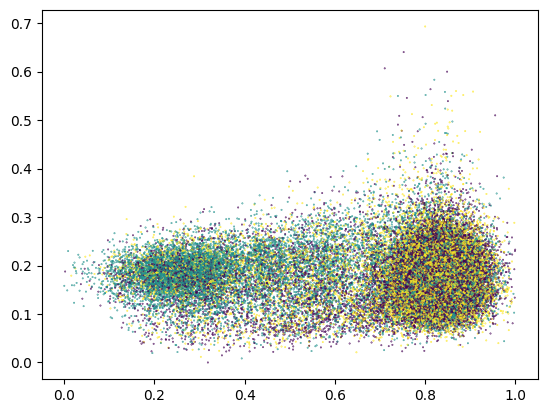

In [13]:
plt.scatter(data["VOL_mean"], data["ALPHA_close"], s = 1/2**3, c = y_bool)

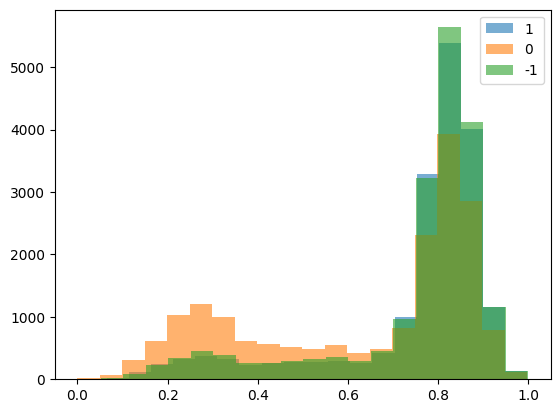

In [14]:
plt.hist(data[y_bool == 1]["VOL_mean"], bins = 20, alpha = 0.6, label = "1")
plt.hist(data[y_bool == 0]["VOL_mean"], bins = 20, alpha = 0.6, label = "0")
plt.hist(data[y_bool == -1]["VOL_mean"], bins = 20, alpha = 0.6, label = "-1")
plt.legend()
plt.show()

In [42]:
from sklearn.svm import OneClassSVM

clf = OneClassSVM()
outliers = clf.fit_predict(data[x_features])

(array([28063.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 28062.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <BarContainer object of 10 artists>)

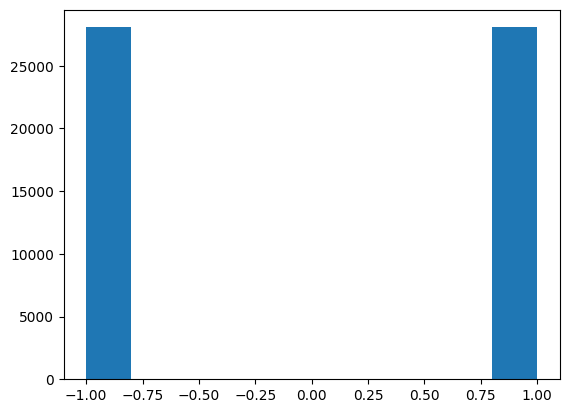

In [43]:
plt.hist(outliers)

(array([1.000e+00, 0.000e+00, 1.000e+00, 2.000e+00, 1.600e+01, 7.100e+01,
        2.320e+02, 7.720e+02, 1.965e+03, 4.110e+03, 6.835e+03, 6.675e+03,
        3.988e+03, 2.097e+03, 8.860e+02, 3.000e+02, 8.400e+01, 1.900e+01,
        6.000e+00, 2.000e+00]),
 array([-86.25949876, -78.44921099, -70.63892322, -62.82863545,
        -55.01834767, -47.2080599 , -39.39777213, -31.58748436,
        -23.77719658, -15.96690881,  -8.15662104,  -0.34633327,
          7.46395451,  15.27424228,  23.08453005,  30.89481782,
         38.7051056 ,  46.51539337,  54.32568114,  62.13596891,
         69.94625669]),
 <BarContainer object of 20 artists>)

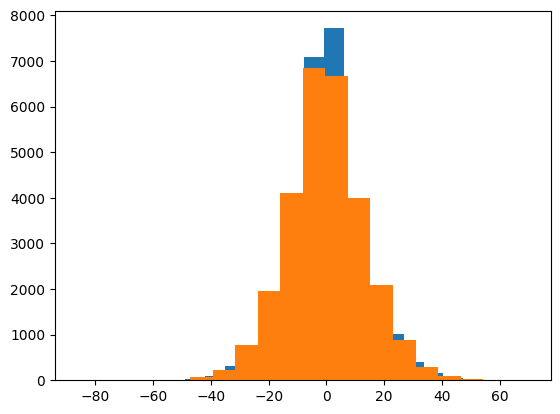

In [47]:
plt.hist(y_diff[outliers == -1], bins = 20)
plt.hist(y_diff[outliers == 1], bins = 20)